## Data Normalization / Preprocessing

### Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### Preprocessing

In [2]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        try:
            self.dataframe = pd.read_csv(file_name)
        except FileNotFoundError:
            print(f"File {file_name} not found.")
        except pd.errors.EmptyDataError:
            print("No data found in the file.")
        except Exception as e:
            print(f"An error occurred: {e}")

    def clean_data(self):
        """Remove null values"""
        self.dataframe = self.dataframe.dropna()

    def print_head(self):
        """Print the first few rows of the dataframe"""
        print(self.dataframe.head())

    def print_description(self):
        """Print the statistical description of the dataframe"""
        print(self.dataframe.describe())

    def normalization(self):
        """Normalize the data frame, excluding the Date column"""
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        numeric_columns = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        self.dataframe[numeric_columns] = self.scaler.fit_transform(self.dataframe[numeric_columns])

        # Separate scaler for 'Close' prices for LSTM
        self.close_scaler = MinMaxScaler(feature_range=(0, 1))
        self.dataframe['Close'] = self.close_scaler.fit_transform(self.dataframe[['Close']])

    def visualize_open(self):
        """Plot graph for open stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Open' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Open'], label='Open Stock Prices')
            plt.title('Open Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Open Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Open column not found in the dataframe")

    def visualize_close(self):
        """Plot graph for close stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Close' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Close'], label='Close Stock Prices')
            plt.title('Close Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Close Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Close column not found in the dataframe")

In [3]:
data = Data()

In [4]:
data.read('Data/AKG.csv')

In [11]:
data.clean_data()

In [12]:
data.print_head()
data.print_description()

         Date      Open      High       Low     Close  Adj Close  Volume
0  2018-10-10  9.133726  9.272116  9.133726  9.272116   9.272116   43355
1  2018-10-11  9.272116  9.272116  9.272116  9.272116   9.272116       0
2  2018-10-12  9.272116  9.272116  9.272116  9.272116   9.272116       0
3  2018-10-15  9.272116  9.272116  9.272116  9.272116   9.272116       0
4  2018-10-16  9.064531  9.064531  8.926142  8.995337   8.995337   43355
              Open         High          Low        Close    Adj Close  \
count  1387.000000  1387.000000  1387.000000  1387.000000  1387.000000   
mean     18.290741    18.671803    17.830421    18.232742    18.232742   
std       9.204636     9.435082     8.879798     9.171637     9.171637   
min       8.303388     8.303388     8.303388     8.303388     8.303388   
25%       9.659608     9.659608     9.597332     9.659608     9.659608   
50%      16.119644    16.662132    15.632511    16.119644    16.119644   
75%      25.519078    26.100000    24.775000

In [13]:
data.normalization()

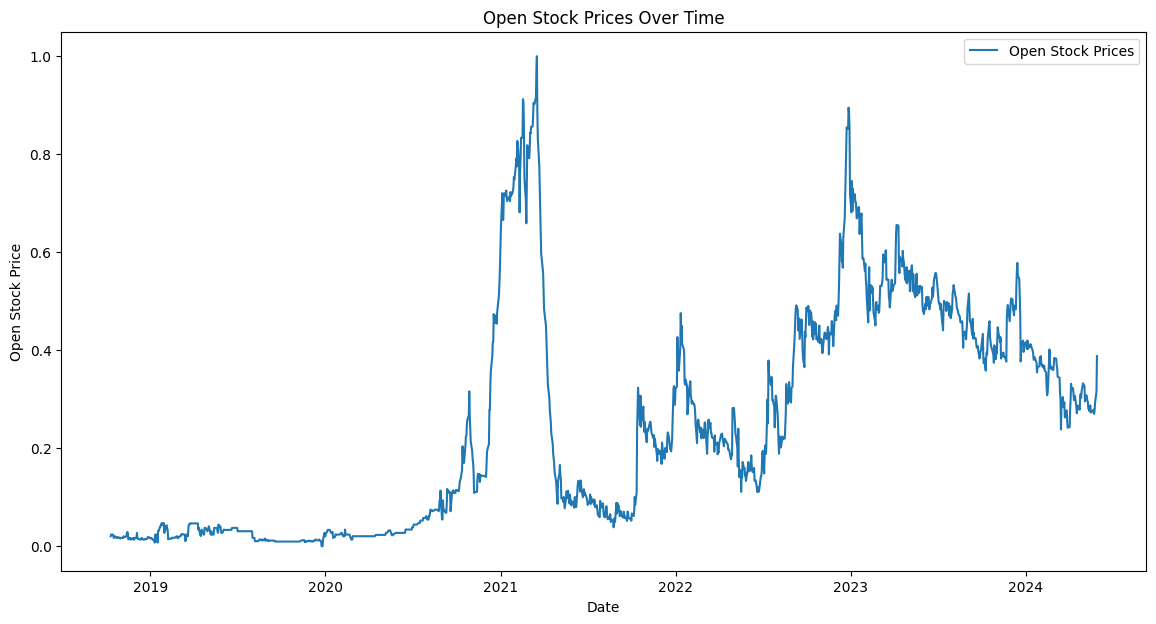

In [14]:
data.visualize_open()

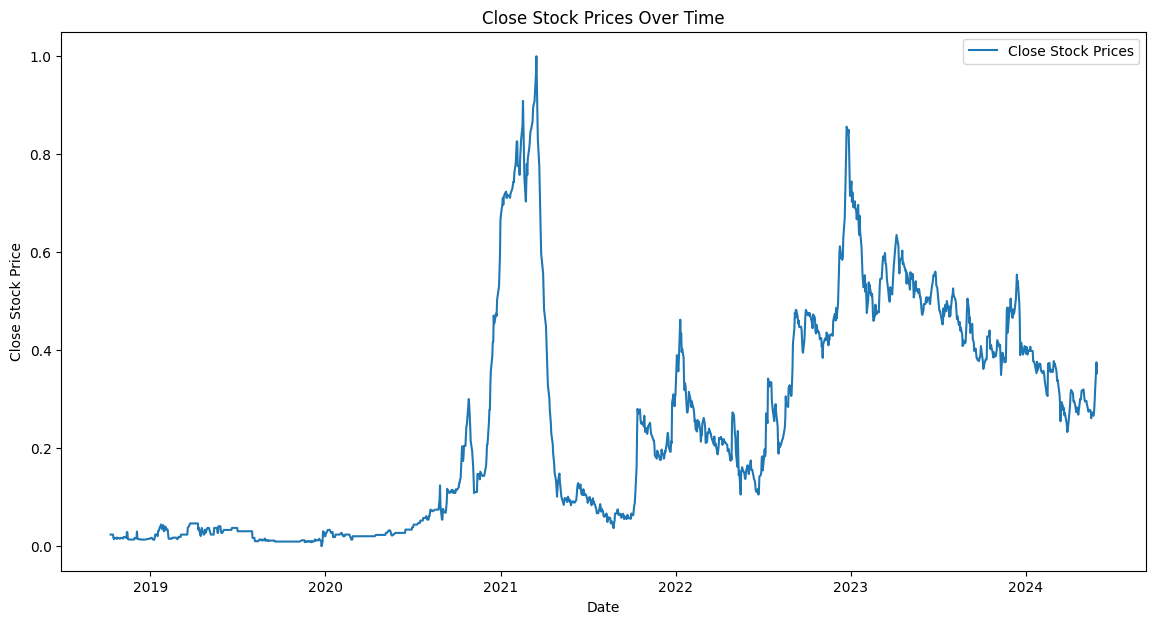

In [9]:
data.visualize_close()

## Model Training

### Imports

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import load_model
import pickle

### LSTM Model Training

In [6]:
class LSTMTrainer:
    def __init__(self, dataframe, scaler, close_scaler):
        self.dataframe = dataframe
        self.scaler = scaler
        self.close_scaler = close_scaler

    def prepare_data_for_lstm(self, feature_col='Close', look_back=60):
        """Prepare data for LSTM by creating sequences"""
        data = self.dataframe[feature_col].values
        data = data.reshape(-1, 1)
        X, y = [], []

        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])

        X, y = np.array(X), np.array(y)

        return train_test_split(X, y, test_size=0.2, shuffle=False)

    def build_and_train_lstm(self, feature_col='Close', look_back=60, epochs=50, batch_size=32):
        """Build and train the LSTM model"""
        X_train, X_test, y_train, y_test = self.prepare_data_for_lstm(feature_col, look_back)

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def predict_and_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.X_test)
        predictions = self.close_scaler.inverse_transform(predictions)
        actual = self.close_scaler.inverse_transform(self.y_test.reshape(-1, 1))

        plt.figure(figsize=(14, 7))
        plt.plot(actual, label='Actual Stock Price')
        plt.plot(predictions, label='Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def evaluate_model(self):
        """Evaluate the model using MSE and MAE"""
        predictions = self.model.predict(self.X_test)
        predictions = self.close_scaler.inverse_transform(predictions)
        actual = self.close_scaler.inverse_transform(self.y_test.reshape(-1, 1))

        mse = mean_squared_error(actual, predictions)
        mae = mean_absolute_error(actual, predictions)

        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")

        return mse, mae

In [15]:
trainer = LSTMTrainer(data.dataframe, data.scaler, data.close_scaler)

In [17]:
trainer.build_and_train_lstm()


Epoch 1/50

34/34 [==============================] - 6s 53ms/step - loss: 0.0184 - val_loss: 0.0015
Epoch 2/50
34/34 [==============================] - 1s 32ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 3/50
34/34 [==============================] - 1s 32ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/50
34/34 [==============================] - 1s 30ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 5/50
34/34 [==============================] - 1s 30ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 6/50
34/34 [==============================] - 1s 32ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 7/50
34/34 [==============================] - 1s 33ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/50
34/34 [==============================] - 1s 32ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/50
34/34 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 9.5773e-04
Epoch 10/50
34/34 [==============================] - 1s 35ms/step - loss: 0.0012 - val_loss: 9.4252e-04

9/9 [==============================] - 1s 9ms/step


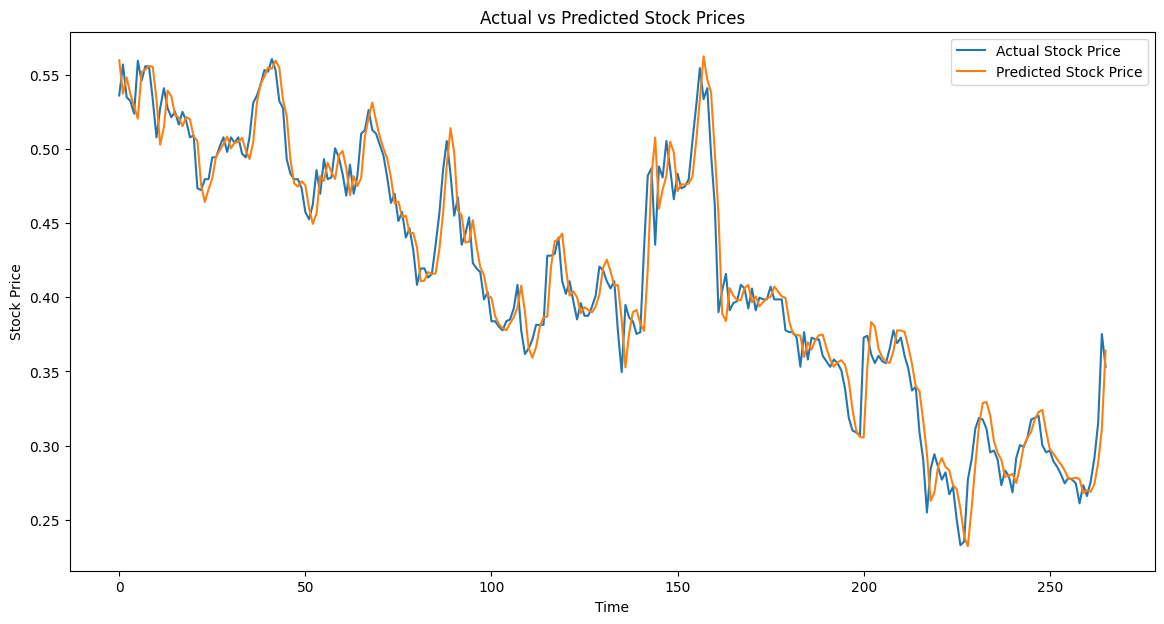

In [18]:
trainer.predict_and_plot()

In [19]:
trainer.evaluate_model()

9/9 [==============================] - 0s 10ms/step
Mean Squared Error: 0.0003416966499776097
Mean Absolute Error: 0.013391241917687324


(0.0003416966499776097, 0.013391241917687324)

In [32]:
with open('akg_model.pkl','wb') as file:
  pickle.dump(trainer,file)

In [33]:
with open('akg_model.pkl','rb') as file:
  trained_model = pickle.load(file)

9/9 [==============================] - 1s 11ms/step


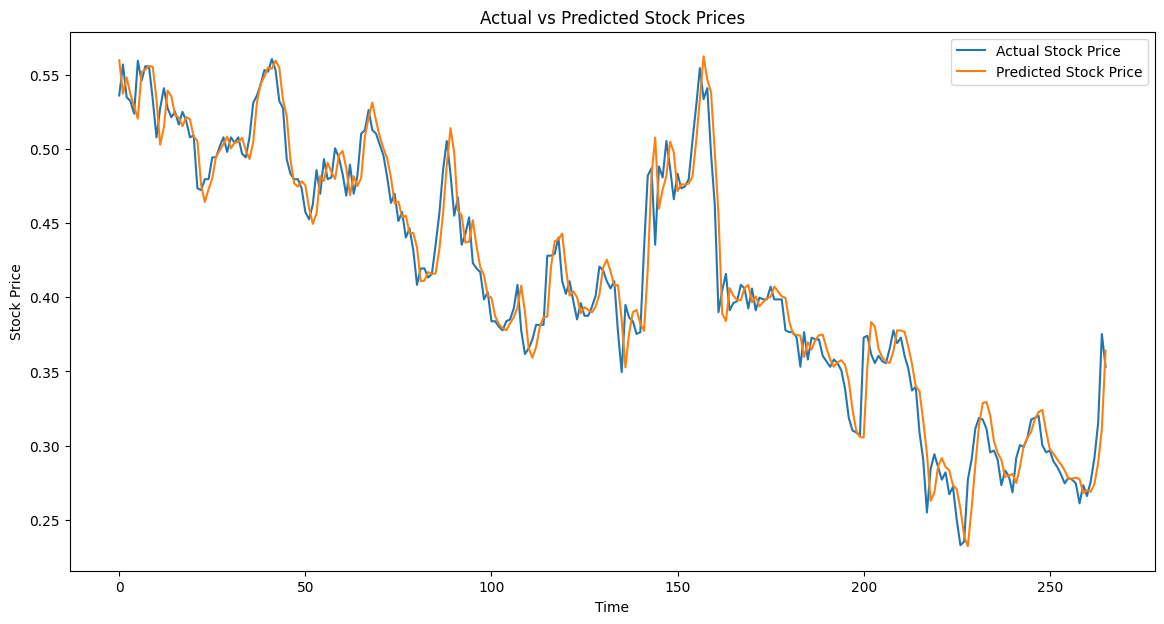

In [34]:
trained_model.predict_and_plot()

In [35]:
trained_model.evaluate_model()

9/9 [==============================] - 0s 10ms/step
Mean Squared Error: 0.0003416966499776097
Mean Absolute Error: 0.013391241917687324


(0.0003416966499776097, 0.013391241917687324)